In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import os
import glob

# Load Config

In [91]:
import configparser

# Load the configuration file
config = configparser.ConfigParser()
config.read('cfg.ini')

# Paths
train_data_path = config['Paths']['TrainData']
test_data_path = config['Paths']['TestData']
model_save_path = config['Paths']['ModelSavePath']

# Data
batch_size = int(config['Data']['BatchSize'])

# Device
device = config['Device']['device']

# Pooling
pool1_size = int(config['Pooling']['Pool1size'])
pool1_stride = int(config['Pooling']['Pool1Stride'])
pool2_size = int(config['Pooling']['Pool2size'])
pool2_stride = int(config['Pooling']['Pool2Stride'])

# Convolutional Layers
kernel_size1 = int(config['Conv']['KernelSize1'])
kernel_size2 = int(config['Conv']['KernelSize2'])
kernel_size3 = int(config['Conv']['KernelSize3'])
conv1_in = int(config['Conv']['Conv1in'])
conv1_out = int(config['Conv']['Conv1out'])
conv2_in = int(config['Conv']['Conv2in'])
conv2_out = int(config['Conv']['Conv2out'])
conv3_in = int(config['Conv']['Conv3in'])
conv3_out = int(config['Conv']['Conv3out'])

# Linear Layers
l1_in = int(config['Linear']['L1in'])
l1_out = int(config['Linear']['L1out'])
l2_in = int(config['Linear']['L2in'])
l2_out = int(config['Linear']['L2out'])
l3_in = int(config['Linear']['L3in'])
l3_out = int(config['Linear']['L3out'])

# View
v1 = int(config['View']['V1'])
v2 = int(config['View']['V2'])

# Training
num_epochs = int(config['Training']['NumEpochs'])
learning_rate = float(config['Training']['LearningRate'])

# Using the values
print(f"Training Data Path: {train_data_path}")
print(f"Test Data Path: {test_data_path}")
print(f"Model Save Path: {model_save_path}")
print(f"Batch Size: {batch_size}")
print(f"Device: {device}")
print(f"Number of Epochs: {num_epochs}")
print(f"Learning Rate: {learning_rate}")
# Add more print statements as needed to display other configurations


Training Data Path: ./data/train
Test Data Path: ./data/test
Model Save Path: ./models
Batch Size: 128
Device: cuda
Number of Epochs: 10
Learning Rate: 0.0001


# Load The Dataset

In [92]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last = True)

Files already downloaded and verified
Files already downloaded and verified


# Design your own Network

# Define Model


In [93]:
class CustomNN(nn.Module):
    def __init__(self):
        super(CustomNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(conv1_in, conv1_out, kernel_size = kernel_size1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool1_size, pool1_stride),
            nn.Conv2d(conv2_in, conv2_out, kernel_size = kernel_size2),
            nn.ReLU(inplace=True),
            nn.Conv2d(conv3_in, conv3_out, kernel_size = kernel_size3),
            nn.MaxPool2d(pool2_size, pool2_stride)
        )

        self.classifier = nn.Sequential(
            nn.Linear(l1_in * 6 * 6, l1_out),
            nn.ReLU(inplace=True),
            nn.Linear(l2_in, l2_out),
            nn.ReLU(inplace=True),
            nn.Linear(l3_in, l3_out)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(v1, v2 * 6 * 6)
        x = self.classifier(x)
        
        return x

# Model Training


In [94]:
model = CustomNN()
model = model.to(device)

In [95]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []
for epoch in range(num_epochs):
    loss_per_epoch = 0
    for images, label in trainloader:
        optimizer.zero_grad()

        images, label = images.to(device), label.to(device)

        outputs = model(images)

        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        loss_per_epoch += loss

    print(f"epoch: {epoch}, loss_per_epoch: {loss_per_epoch}")
    loss_history.append(loss_per_epoch.cpu().detach().numpy())

# Question: Why I increase the batch size, the loss_per_epoch will decrease?
# Write your answer here.

epoch: 0, loss_per_epoch: 700.6972045898438
epoch: 1, loss_per_epoch: 575.482666015625
epoch: 2, loss_per_epoch: 531.0587768554688
epoch: 3, loss_per_epoch: 503.8694763183594
epoch: 4, loss_per_epoch: 479.9013366699219
epoch: 5, loss_per_epoch: 459.24688720703125
epoch: 6, loss_per_epoch: 440.0795593261719
epoch: 7, loss_per_epoch: 422.7347412109375
epoch: 8, loss_per_epoch: 406.15936279296875
epoch: 9, loss_per_epoch: 391.6275634765625


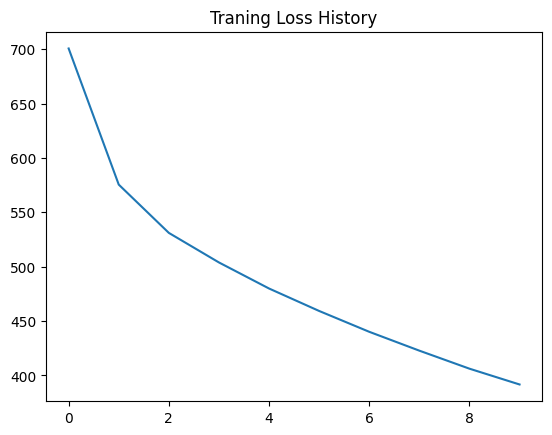

In [96]:
plt.plot(list(range(num_epochs)), loss_history)
plt.title("Traning Loss History")
plt.show()

# Model Testing

In [97]:
# Test the model and show some predictions
correct = 0
total = 0

with torch.no_grad():
    for images, label in testloader:
        images, label = images.to(device), label.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

print(f"Test Accuracy: {correct/total}")

Test Accuracy: 0.6337139423076923


In [98]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

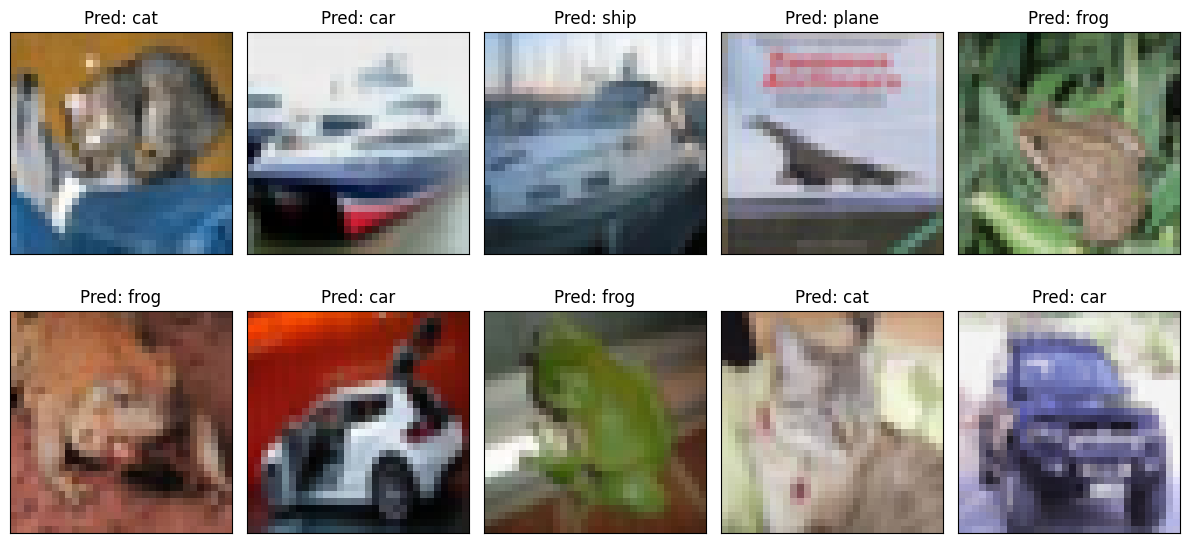

In [99]:
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

# Predict
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(12, 6))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(images[i].cpu().numpy().transpose((1, 2, 0)) * 0.5 + 0.5)
    ax.set_title('Pred: %s' % classes[predicted[i]])
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Logging

In [106]:
import logging
import configparser
from datetime import datetime
log_directory = '/home/vglalala/PycharmProjects/AIProject/log'
# Set up basic configuration for logging
logging.basicConfig(filename=f'{log_directory}/project_log_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.log',
                    level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Function to log the configuration settings
def log_config(config_path):
    config = configparser.ConfigParser()
    config.read(config_path)
    for section in config.sections():
        for key in config[section]:
            logging.info(f"CONFIG - {section} - {key}: {config[section][key]}")

# Example function to log training progress
def log_training(epoch, loss_per_epoch):
    """Log the loss per epoch during training."""
    logging.info(f"TRAINING - Epoch: {epoch}, Loss per Epoch: {loss_per_epoch}")


logging.info(f"TEST - Accuracy: {correct/total}")


# Assuming you have a config file named 'settings.ini'
log_config('cfg.ini')

for i in range(1,num_epochs+1):
    loss = loss_history[i-1]
    log_training(i,loss)